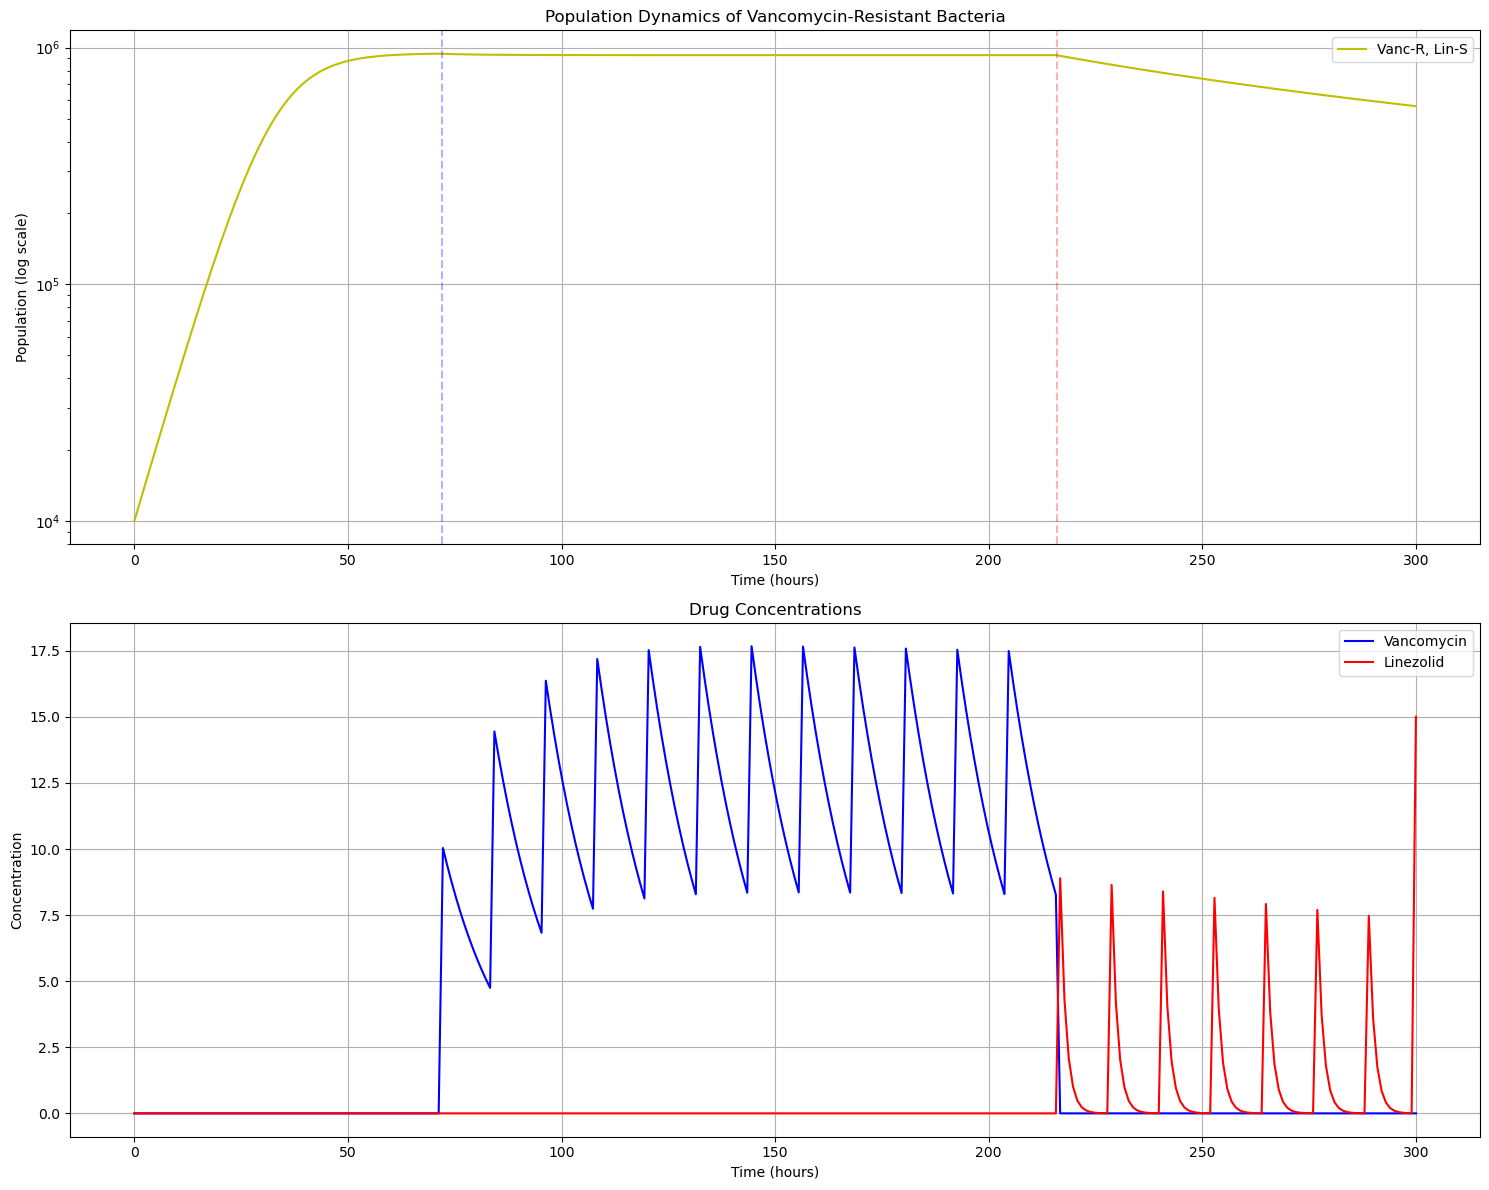

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Previous concentration and Ke functions remain the same
def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains population:
    R: Resistant to vancomycin, Sensitive to linezolid
    """
    R = state[0]
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Drug effects with Hill equation for linezolid
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t**hill_coeff / (conc_linez_t**hill_coeff + EC50_linez**hill_coeff))
    
    # Population dynamics without explicit killing
    dRdt = R * (
        rho * (1 - R/k) *
        (1 - resistance_factor_vanco * vanco_effect) * 
        (1 - linez_effect) -
        delta
    )
    
    return [dRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 600,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 12,  # hours
}

# Updated model parameters without killing rate
model_params = {
    # Growth rate
    'rho': 0.15,      
    
    # Death rate
    'delta': 0.008,   
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.00015,  
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.95,  
    'hill_coeff': 4.0,    
    
    # Resistance factor
    'resistance_factor_vanco': 0.3,
}

def simulate_resistance_dynamics(
    initial_condition=1e4,
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial population with vancomycin resistance"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        [initial_condition],
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'y-', label='Vanc-R, Lin-S')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics of Vancomycin-Resistant Bacteria')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Add vertical lines for treatment periods
    ax1.axvline(x=treatment_params['no_drug_period'], color='b', linestyle='--', alpha=0.3)
    ax1.axvline(x=treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'], 
                color='r', linestyle='--', alpha=0.3)
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()